# Apartat (C): Analitzant Dades

In [6]:
import sklearn
import numpy as np
import matplotlib
import scipy
import pandas as pd
from sklearn.datasets import make_regression
from matplotlib import pyplot as plt
import scipy.stats

# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset
# Carreguem dataset d'exemple
dataset = load_dataset('COMBO17.csv')
data = dataset.values

x = data[:, :2]
y = data[:, 2]

# Per veure les dimensionalitats
print("Dimensionalitat de la BBDD:", dataset.shape)
print("Dimensionalitat de les entrades X:", x.shape)
print("Dimensionalitat de l'atribut Y:", y.shape)

Dimensionalitat de la BBDD: (3462, 65)
Dimensionalitat de les entrades X: (3462, 2)
Dimensionalitat de l'atribut Y: (3462,)


In [7]:
# Per veure totes les columnes amb valors inexistents
x = dataset.isnull().sum()
null_columns = dataset.columns[dataset.isnull().any()]
print(null_columns)
print(dataset[null_columns].isnull().sum())
print("Total de valors no existents:")
print(dataset.isnull().sum().sum())
# Tipus de cada atribut: 
print(dataset.dtypes)

dataset1 = dataset
dataset1 = dataset1.dropna()
dataset1.drop(columns='Nr')
print("Total de valors no existents:")
print(dataset1.isnull().sum().sum())
    

Index(['VnMAG', 'e.VbMAG', 'S280MAG', 'e.S280MA'], dtype='object')
VnMAG        1
e.VbMAG      1
S280MAG     24
e.S280MA    24
dtype: int64
Total de valors no existents:
50
Nr           int64
Rmag       float64
e.Rmag     float64
ApDRmag    float64
mumax      float64
            ...   
e.VFD      float64
RFS        float64
e.RFS      float64
IFD        float64
e.IFD      float64
Length: 65, dtype: object
Total de valors no existents:
0


In [20]:
from scipy.stats import norm
from scipy.stats import shapiro


#print(dataset1)

"""
ee = dataset1.columns

ix = 0
print(shapiro(dataset1[ee[ix]]))
ix = ix + 1
print(shapiro(dataset1[ee[ix]]))


i = 0
while i < ee.size:
    print(i, ee[i], dataset1[ee[i]])
    shapiro(dataset1[ee[i]])
    i += 1

"""
    

'\nee = dataset1.columns\n\nix = 0\nprint(shapiro(dataset1[ee[ix]]))\nix = ix + 1\nprint(shapiro(dataset1[ee[ix]]))\n\n\ni = 0\nwhile i < ee.size:\n    print(i, ee[i], dataset1[ee[i]])\n    shapiro(dataset1[ee[i]])\n    i += 1\n\n'

In [17]:
dataset1 = load_dataset('COMBO17.csv')
dataset1 = dataset1.dropna()


dataTypeDict = dict(dataset1.dtypes)

#creamos una lista para seleccionar los nombres de columnas que queremos dropear
lst = []

print(dataTypeDict)

for x in dataTypeDict:
    lst.append(x)
    print(x)
    print(dataTypeDict[x])



{'Nr': dtype('int64'), 'Rmag': dtype('float64'), 'e.Rmag': dtype('float64'), 'ApDRmag': dtype('float64'), 'mumax': dtype('float64'), 'Mcz': dtype('float64'), 'e.Mcz': dtype('float64'), 'MCzml': dtype('float64'), 'chi2red': dtype('float64'), 'UjMAG': dtype('float64'), 'e.UjMAG': dtype('float64'), 'BjMAG': dtype('float64'), 'e.BjMAG': dtype('float64'), 'VjMAG': dtype('float64'), 'e.VjMAG': dtype('float64'), 'usMAG': dtype('float64'), 'e.usMAG': dtype('float64'), 'gsMAG': dtype('float64'), 'e.gsMAG': dtype('float64'), 'rsMAG': dtype('float64'), 'e.rsMAG': dtype('float64'), 'UbMAG': dtype('float64'), 'e.UbMAG': dtype('float64'), 'BbMAG': dtype('float64'), 'e.BbMAG': dtype('float64'), 'VnMAG': dtype('float64'), 'e.VbMAG': dtype('float64'), 'S280MAG': dtype('float64'), 'e.S280MA': dtype('float64'), 'W420FE': dtype('float64'), 'e.W420FE': dtype('O'), 'W462FE': dtype('float64'), 'e.W462FE': dtype('float64'), 'W485FD': dtype('float64'), 'e.W485FD': dtype('float64'), 'W518FE': dtype('float64'), 

In [23]:
dataset1 = load_dataset('COMBO17.csv')
dataset1.describe()

#drop de la columna de indice
dataset1 = dataset1.drop(columns='Nr')

#quitamos las columnas entre la 56 y la 65 al ser valores redundantes de las 13 anteriores
listt = lst[-10:]

#quitamos mumax y ApDRmag
listt.append('mumax')
listt.append('ApDRmag')

#is_numeric_dtype(df['B'])

#drop de las columnas que den info acerca de los errores
for x in lst:
    if "e." in x:
        listt.append(x)
        
dataset1 = dataset1.drop(columns=listt)
print(dataset1)


       Rmag   Mcz  MCzml  chi2red   UjMAG   BjMAG   VjMAG   usMAG   gsMAG  \
0    24.995 0.832  1.400    0.640 -17.670 -17.540 -17.760 -17.830 -17.600   
1    25.013 0.927  0.864    0.410 -18.280  17.860 -18.200 -18.420 -17.960   
2    24.246 1.202  1.217    0.920 -19.750 -19.910 -20.410 -19.870 -20.050   
3    25.203 0.912  0.776    0.390 -17.830 -17.390 -17.670 -17.980 -17.470   
4    25.504 0.848  1.330    1.450 -17.690 -18.400 -19.370 -17.810 -18.690   
...     ...   ...    ...      ...     ...     ...     ...     ...     ...   
3457 24.962 0.960  0.951    0.890 -18.210 -17.970 -18.270 -18.350 -18.050   
3458 21.918 0.770  0.766    0.900 -20.470 -20.350 -20.660 -20.620 -20.440   
3459 23.701 0.775  1.330    0.600 -18.760 -18.360 -18.590 -18.950 -18.500   
3460 23.473 0.926  0.870    1.010 -19.670 -19.580 -19.890 -19.820 -19.670   
3461 25.621 0.968  0.957    1.130 -17.700 -17.810 -18.310 -17.830 -17.950   

       rsMAG  ...  W518FE  W571FS  W604FE  W646FD  W696FE  W753FE  W815FS  

In [35]:

dataTypeDict = dict(dataset1.dtypes)
dataset1.describe()
dataset1 = dataset1.dropna()

print("Total de valors no existents:")
print(dataset1.isnull().sum().sum())
    
ee = dataset1.columns


print("Executem els test per comprobar si son normalitzades:")
for col in ee:
    shapiro_test = shapiro(dataset1[col])
    yy = round(shapiro_test.pvalue, 5)
    print(col, yy)


Total de valors no existents:
0
Executem els test per comprobar si son normalitzades:
Rmag 0.0
Mcz 0.0
MCzml 0.0
chi2red 0.0
UjMAG 0.0
BjMAG 0.0
VjMAG 0.0
usMAG 0.0
gsMAG 0.0
rsMAG 0.0
UbMAG 0.0
BbMAG 0.0
VnMAG 0.0
S280MAG 0.0
W420FE 0.0
W462FE 0.0
W485FD 0.0
W518FE 0.0
W571FS 0.0
W604FE 0.0
W646FD 0.0
W696FE 0.0
W753FE 0.0
W815FS 0.0
W856FD 0.0
W914FD 0.0
W914FE 0.0


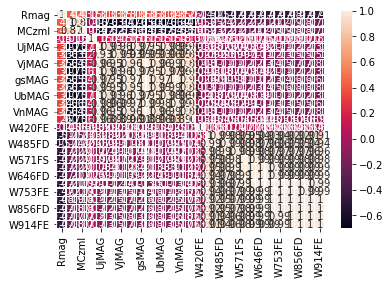

In [38]:
import seaborn as sns

# Mirem la correlació entre els atributs d'entrada per entendre millor les dades
correlacio = dataset1.corr()

plt.figure()

ax = sns.heatmap(correlacio, annot=True, linewidths=.1)